# Quick start
In this tutorial, we will show case main features of scDRS.

In [1]:
import scdrs

import pandas as pd
import scanpy as sc
sc.set_figure_params(dpi=125)

from anndata import AnnData

import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
CORTEX_URL = "https://storage.googleapis.com/linnarsson-lab-www-blobs/blobs/cortex/expression_mRNA_17-Aug-2014.txt"
SUPP_TABLE_URL = "https://www.dropbox.com/s/qojbzu5zln33j7f/supp_tables.xlsx?dl=1"

# Compile dataset
We will download cortex scRNA-seq data set and disease gene sets.

In [3]:
# meta information
df_meta = pd.read_csv(CORTEX_URL, nrows=10, sep="\t", header=None)
df_meta = df_meta.iloc[:, 1:].T
columns = df_meta.iloc[0, :]
df_meta = df_meta.iloc[1:, :]
df_meta.columns = columns
df_meta = df_meta.set_index("cell_id")
df_meta.columns.name = None
df_meta["total mRNA mol"] = df_meta["total mRNA mol"].astype(float)

# expression information
df_expr = pd.read_csv(CORTEX_URL, skiprows=11, sep="\t", header=None).set_index(0)
df_expr.index.name = "gene"
# 1st column in backspin cluster, we don't need it here
df_expr = df_expr.iloc[:, 1:]
df_expr.columns = df_meta.index
df_expr = df_expr.T
raw_adata = AnnData(df_expr, obs=df_meta)

# assemble AnnData
sc.pp.filter_cells(raw_adata, min_genes=0)
sc.pp.filter_genes(raw_adata, min_cells=30)

raw_adata.raw = raw_adata

sc.pp.normalize_total(raw_adata, target_sum=1e4)
sc.pp.log1p(raw_adata)
sc.pp.highly_variable_genes(raw_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

raw_adata = raw_adata[:, raw_adata.var.highly_variable]

sc.pp.scale(raw_adata, max_value=10)
sc.tl.pca(raw_adata, svd_solver="arpack")
sc.pp.neighbors(raw_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(raw_adata)
sc.tl.leiden(raw_adata)

adata = raw_adata.raw.to_adata()
adata.obsp = raw_adata.obsp
adata.X = adata.X

# compile covariates
df_cov = pd.DataFrame(index=adata.obs.index)
df_cov["const"] = 1
df_cov["n_genes"] = adata.obs["n_genes"]

# load gene sets
df_gs = pd.read_excel(SUPP_TABLE_URL, sheet_name="ST6 MAGMA gene sets", index_col=0)
df_gs = df_gs.loc[["PASS_Schizophrenia_Pardinas2018", "UKB_460K.body_HEIGHTz"], :]
df_gs = scdrs.util.convert_gs_species(df_gs)
df_gs = df_gs.rename(
    index={"PASS_Schizophrenia_Pardinas2018": "SCZ", "UKB_460K.body_HEIGHTz": "Height"}
)

# save to files
if not os.path.exists("data/"):
    os.makedirs("data/")

adata.write_h5ad("data/expr.h5ad")
df_cov.to_csv("data/cov.tsv", sep="\t")
df_gs.reset_index().to_csv("data/geneset.gs", sep="\t", index=False)

... storing 'tissue' as categorical
... storing 'group #' as categorical
... storing 'well' as categorical
... storing 'sex' as categorical
... storing 'age' as categorical
... storing 'diameter' as categorical
... storing 'level1class' as categorical
... storing 'level2class' as categorical


# use `scDRS` to score cells with disease enrichment

In [4]:
!python ../../compute_score.py \
    --h5ad_file data/expr.h5ad \
    --h5ad_species mouse \
    --gs_file data/geneset.gs \
    --gs_species mouse \
    --cov_file data/cov.tsv \
    --flag_filter True \
    --flag_raw_count True \
    --flag_return_ctrl_raw_score False \
    --flag_return_ctrl_norm_score True \
    --out_folder data/

******************************************************************************
* Single-cell disease relevance score (scDRS)
* Version beta
* Martin Jinye Zhang and Kangcheng Hou
* HSPH / Broad Institute / UCLA
* MIT License
******************************************************************************
Call: ./compute_score.py \
--h5ad_file data/expr.h5ad\
--h5ad_species mouse\
--cov_file data/cov.tsv\
--gs_file data/geneset.gs\
--gs_species mouse\
--ctrl_match_opt mean_var\
--weight_opt vs\
--flag_filter True\
--flag_raw_count True\
--n_ctrl 1000\
--flag_return_ctrl_raw_score False\
--flag_return_ctrl_norm_score True\
--out_folder data/

Load data:
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
--h5ad_file loaded: n_cell=3005, n_gene=13572 (sy

# Overlay disease score on UMAP

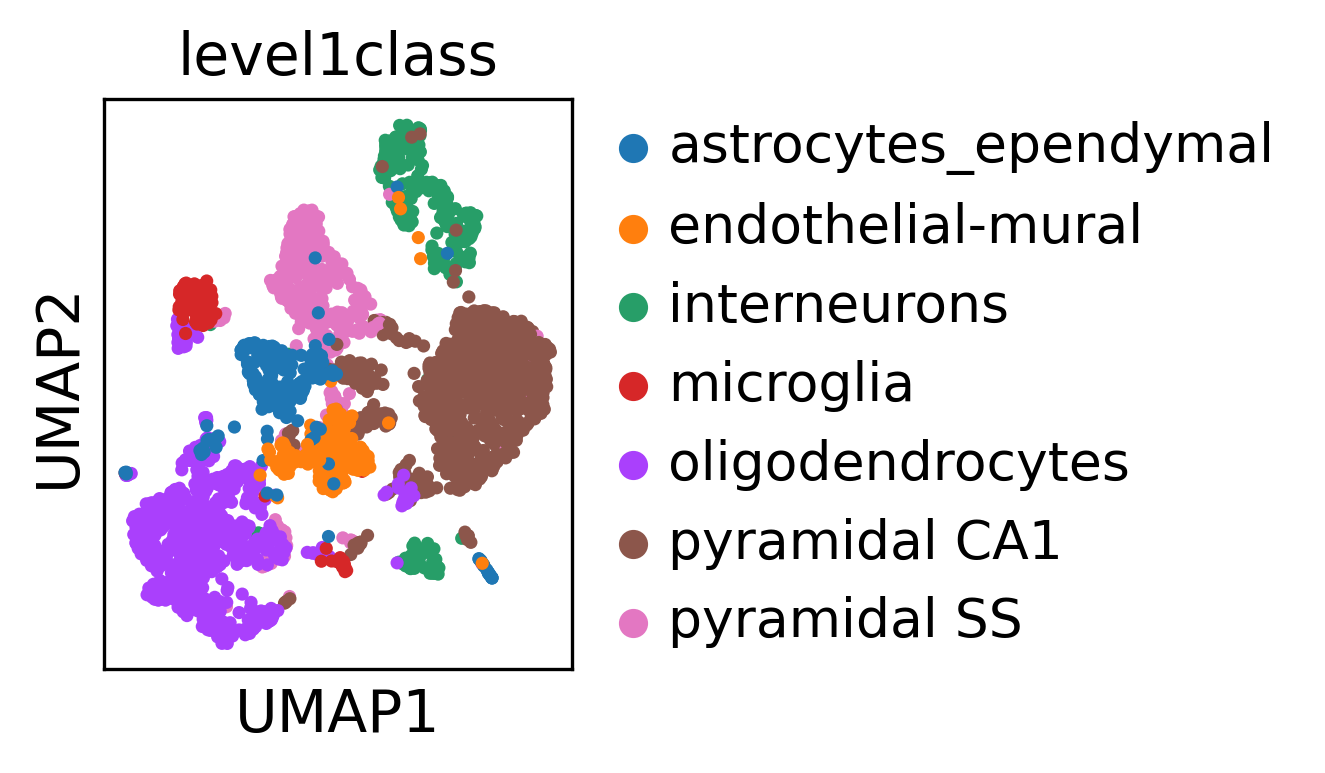

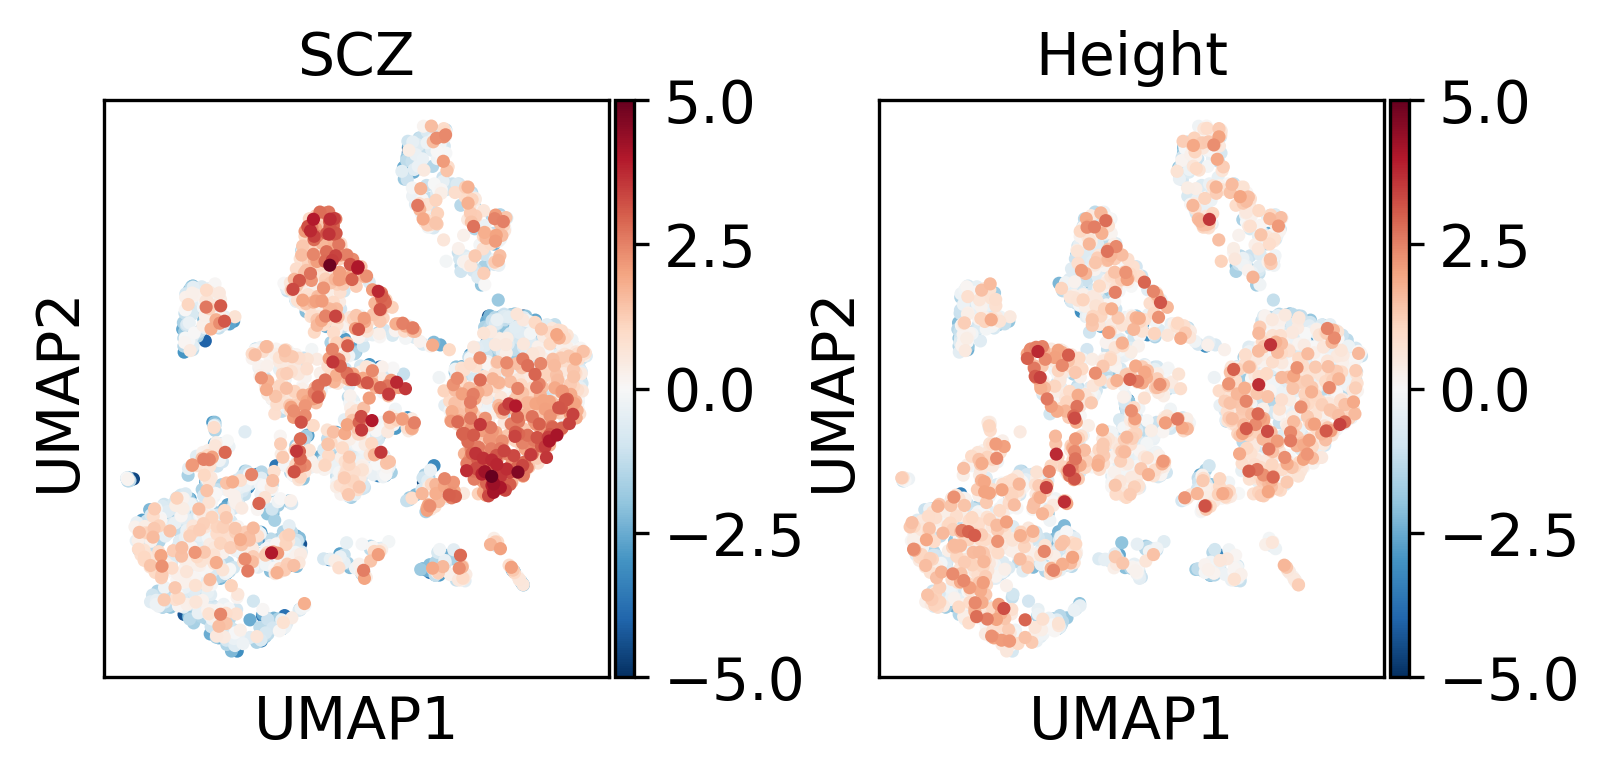

In [5]:
dict_score = {
    trait: pd.read_csv(f"data/{trait}.full_score.gz", sep="\t", index_col=0)
    for trait in df_gs.index
}

for trait in dict_score:
    adata.obs[trait] = dict_score[trait]["norm_score"]

sc.set_figure_params(figsize=[2, 2.5], dpi=150)
sc.pl.umap(
    adata,
    color="level1class",
    ncols=1,
    color_map="RdBu_r",
    vmin=-5,
    vmax=5,
)

sc.pl.umap(
    adata,
    color=dict_score.keys(),
    color_map="RdBu_r",
    vmin=-5,
    vmax=5,
)

# Cell type level analyses
We stratify using the existing cell type annotation to perform a cell type level analyses.

We use `scdrs.util.group_stats` to obtain the group-level statistics. The function will return the following statistics for each cell type:
1. `fdr_prop`: the proportion of significantly associated cells (FDR$<$0.1 across all cells for a given disease)
2. `assoc_pval`: significance of cell type-disease association
3. `hetero_pval`: significance heterogeneity in association with disease across individual cells within a given cell type

In [6]:
dict_stats = dict()
for trait in dict_score:
    dict_stats[trait] = scdrs.util.group_stats(
        dict_score[trait], adata, group_col="level1class"
    )

# show stats for SCZ
display(dict_stats["SCZ"])

,n_cell,n_ctrl,fdr_prop,assoc_pval,assoc_zsc,hetero_pval,hetero_zsc
astrocytes_ependymal,224.0,1000.0,0.049107,0.007992,2.589284,0.001998,3.104803
endothelial-mural,235.0,1000.0,0.034043,0.177822,0.895284,0.080919,1.417222
interneurons,290.0,1000.0,0.010345,0.277722,0.533180,0.003996,2.999981
microglia,98.0,1000.0,0.020408,0.212787,0.788619,0.117882,1.192168
oligodendrocytes,820.0,1000.0,0.002439,0.792208,-0.849913,0.000999,5.186321
pyramidal CA1,939.0,1000.0,0.112886,0.000999,7.480655,0.000999,10.014501
pyramidal SS,399.0,1000.0,0.112782,0.000999,5.689697,0.000999,5.945165


We can also visualize the three statistics simulateously using the built-in `scdrs.util.plot_group_stats`: 
1. Heatmap colors for each cell type-disease pair denote the proportion of significantly associated cells.
2. Squares denote significant cell type-disease associations (FDR$<$0.05 across all pairs of cell types and diseases/traits.
3. Cross symbols denote significant heterogeneity in association with disease across individual cells within a given cell type.

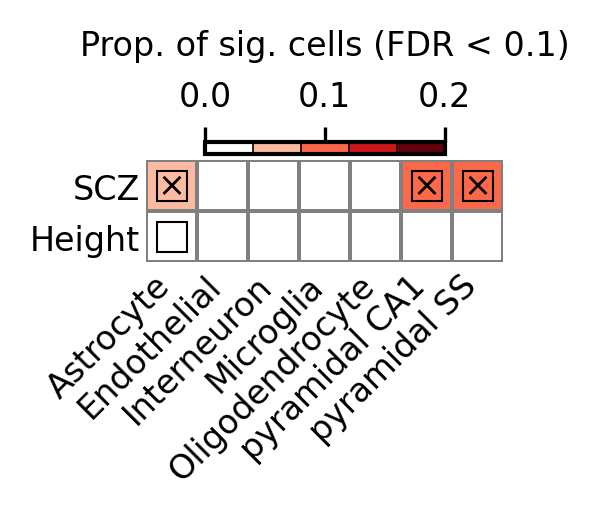

In [7]:
dict_celltype_display_name = {
    "pyramidal_CA1": "Pyramidal CA1",
    "oligodendrocytes": "Oligodendrocyte",
    "pyramidal_SS": "Pyramidal SS",
    "interneurons": "Interneuron",
    "endothelial-mural": "Endothelial",
    "astrocytes_ependymal": "Astrocyte",
    "microglia": "Microglia",
}

scdrs.util.plot_group_stats(
    {
        trait: df_stats.rename(index=dict_celltype_display_name)
        for trait, df_stats in dict_stats.items()
    }
)